## Building a superresolution network

In [1]:
#imports
import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils

import haiku as hk
import gin
import numpy as np
import xarray
import random

import pickle
from diego_model_utils import SaveObject, forward_pass_module

import matplotlib.pyplot as plt
import seaborn

In [5]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})


In [6]:
# # split by timestamps
# x_shape = len(data.x)
# y_shape = len(data.y)
# high_def = []
# for i in range(int(len(data.time))):
#     this_time_u = jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape)
#     this_time_v = jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
#     this_time = [this_time_u, this_time_v]
#     high_def.append(this_time)

In [7]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = jnp.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
    ])
    high_def.append(this_time)

In [8]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


In [9]:
high_def = high_def[0::20]

In [10]:
np.shape(high_def)

(432, 256, 64, 2)

In [11]:
originalMax = np.max(high_def)
originalMin = (np.min(high_def))
print(originalMin,originalMax)

-0.77263814 1.0149648


In [12]:
# scale velocities to beetween zero and one
def scale(input, min=0, max=1):
    
    if min>max:
        raise(ValueError("Min and max may be the wrong way around"))
    
    if min<0:
        og_min = min
        max += -min
        min = 0

    
    input += (min-np.min(input))
    input /= (np.max(input)/max)
    
    try:
        input += og_min
    except:
        pass
    return input


def scaleAllVelocities(high_def,allVels=False):
    
    scaled = []
    for vels in high_def:
        both_vels = []
        for vel in vels:
            vel = scale(vel,min=0,max=1)
            both_vels.append(vel)
        scaled.append(both_vels)
    return scaled

In [13]:
def scaleAllTimes(data):
    out = []
    for i in range(len(data)):
        this_time = jnp.dstack([
            scale(data[i][:,:,0]),
            scale(data[i][:,:,1])
        ])
        
        
        out.append(this_time)
    return out

In [14]:
# scaled_high_def = scaleAllVelocities(high_def,allVels=True) #scales each frame from 0 to 1
scaled_high_def = scaleAllTimes(high_def) #scales all timesteps to same max and min

In [15]:
np.shape(scaled_high_def)

(432, 256, 64, 2)

In [16]:
def increaseSize(input, factor):
    w,h = np.shape(input)
    output = np.zeros((w*factor,h*factor))
    
    for width in range(w*factor):
        for height in range(h*factor):
            output[width][height] = input[width//factor][height//factor]
    return output


def decreaseSize(input,factor):
    w,h = np.shape(input)
    if w%factor != 0 or h%factor != 0:
        raise(AssertionError("Non-compatible input shape and downsample factor"))
    
    output = np.zeros((int(w/factor),int(h/factor)))
    
    for width in range(w):
        for height in range(h):
            output[width//factor][height//factor] += input[width][height]
    output /= factor**len(np.shape(output))
    return output

def downsampleHighDefVels(high_def,factor):
    low_def = []
    for vels in high_def:
        both_vels = []
        for vel in vels:
            vel = decreaseSize(vel,factor)

            vel = increaseSize(vel,factor)
            both_vels.append(vel)
        low_def.append(both_vels)
    return low_def

def downsampleHighDefVelsNumpy(high_def,factor):
    """
    Same as downsampleHighDefVels but running the resizings on numpy arrays
    due to performance issues with these funcitions and DeviceArrays
    """
    low_def = []
    for vels in high_def:
        
        u = decreaseSize(np.array(vels[:,:,0]),factor) #output is a np.array
        u = jnp.array(increaseSize(u,factor)) #output is a DeviceArray
        
        v = decreaseSize(np.array(vels[:,:,1]),factor) #output is a np.array
        v = jnp.array(increaseSize(v,factor)) #output is a DeviceArray
        
        low_def.append(jnp.dstack([
            u,
            v
        ]))
    return low_def

In [17]:
#converting lists of images to DeviceArray with correct shape

def convertListToDeviceArray(list):
    new_list = []
    for i in range(len(list)):

        new_list.append(
            jnp.dstack([
                jnp.array(list[i][0]),
                jnp.array(list[i][1])]
            )
        )
    return jnp.array(new_list)



In [18]:
type(scaled_high_def[0])

jaxlib.xla_extension.DeviceArray

In [19]:
#split into train and test

split = 0.8
split = int(len(scaled_high_def)*split//1)
random.shuffle(high_def)

factor = 4



%time scaled_low_def = downsampleHighDefVelsNumpy(scaled_high_def,factor)
#conv_scaled_high_def = convertListToDeviceArray(scaled_high_def)
#conv_scaled_low_def = convertListToDeviceArray(scaled_low_def)

conv_scaled_high_def = scaled_high_def
conv_scaled_low_def = scaled_low_def

X_train = conv_scaled_low_def[:split]
Y_train = conv_scaled_high_def[:split]

X_test = conv_scaled_low_def[split:]
Y_test = conv_scaled_high_def[split:]



CPU times: user 16.7 s, sys: 13.7 ms, total: 16.7 s
Wall time: 16.8 s


In [20]:
def printAllShapes(*things):
    for thing in things:
        print(np.shape(thing))

printAllShapes(X_train,Y_train, X_test,Y_test)

(345, 256, 64, 2)
(345, 256, 64, 2)
(87, 256, 64, 2)
(87, 256, 64, 2)


In [21]:
np.shape(X_train[0])

(256, 64, 2)

In [22]:
# def toDeviceArrays(data):
#     for i in range(len(data)):
#         this_time = []
#         for j in range(len(data[i])):
#             this_time.append(jnp.array(data[i][j]))
#         data[i] = this_time
#     return data

In [23]:
# X_train = toDeviceArrays(X_train)
# Y_train = toDeviceArrays(Y_train)

# X_test = toDeviceArrays(X_test)
# Y_test = toDeviceArrays(Y_test)

In [24]:
def getUorV(data, u=0,xlen=256,ylen=64):
    out = []
    for point in data:
        out.append(
            jnp.dstack([
                point[:,:,u].reshape(xlen,ylen),
                point[:,:,u].reshape(xlen,ylen)
            ])
        )
    return out

In [25]:
np.shape(X_train)

(345, 256, 64, 2)

In [26]:
#extract u from u and v
# diego = getUorV(X_train)

# X_train = getUorV(X_train)
# Y_train = getUorV(Y_train)

# X_test = getUorV(X_test)
# Y_test = getUorV(Y_test)

In [27]:
#reference:
# https://goodboychan.github.io/python/deep_learning/vision/tensorflow-keras/2020/10/13/01-Super-Resolution-CNN.html#Build-SR-CNN-Model

def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= float(target_data.shape[0] * target_data.shape[1])
    return err

In [28]:
def my_mse(pred,actual):
    err = (jnp.array(pred)-jnp.array(actual))**2
    return err.mean()


# print(jnp.array(mse(truth,pred)))
# print(jnp.power(jnp.array(truth) - jnp.array(pred), 2).mean())
# print(my_mse(pred,truth))

In [30]:
num_output_channels = 2
# spatial_size = 17
ndim = 2
input_channels = 2

rng_key = jax.random.PRNGKey(42)
tower_module = towers.forward_tower_factory #add scaling here

forward_pass = forward_pass_module(num_output_channels = num_output_channels, 
                                    ndim = ndim,
                                    tower_module = tower_module)
                                

forward_pass = hk.without_apply_rng(hk.transform(forward_pass))

In [31]:
# Reference:
# https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-guide-to-create-multi-layer-perceptrons-using-jax

In [34]:
def computePredAndTruth(params,input_data,actual):
    preds = []
    truth = []
    for i in range(len(input_data)):
        preds.append(forward_pass.apply(params, input_data[i]))
        truth.append(actual[i])
    return preds,truth






def UpdateWeights(weights,gradients):
    return weights - learning_rate * gradients

In [35]:
#this one works 
def MeanSquaredErrorLoss(params, input_data, actual):
    preds,truth = computePredAndTruth(params,input_data,actual)
    return jnp.power(jnp.array(truth) - jnp.array(preds), 2).mean()

def absErrorLoss(params,input_data,actual):
    preds,truth = computePredAndTruth(params,input_data,actual)
    return ((jnp.array(truth) - jnp.array(preds))).mean()

def train_step(params, X_train, Y_train,X_val,Y_val):
    loss, param_grads = value_and_grad(MeanSquaredErrorLoss)(params, X_train, Y_train)
    val_loss = MeanSquaredErrorLoss(params, X_val,Y_val)
    return jax.tree_map(UpdateWeights, params, param_grads), loss, val_loss

0.026345992
0.043321952


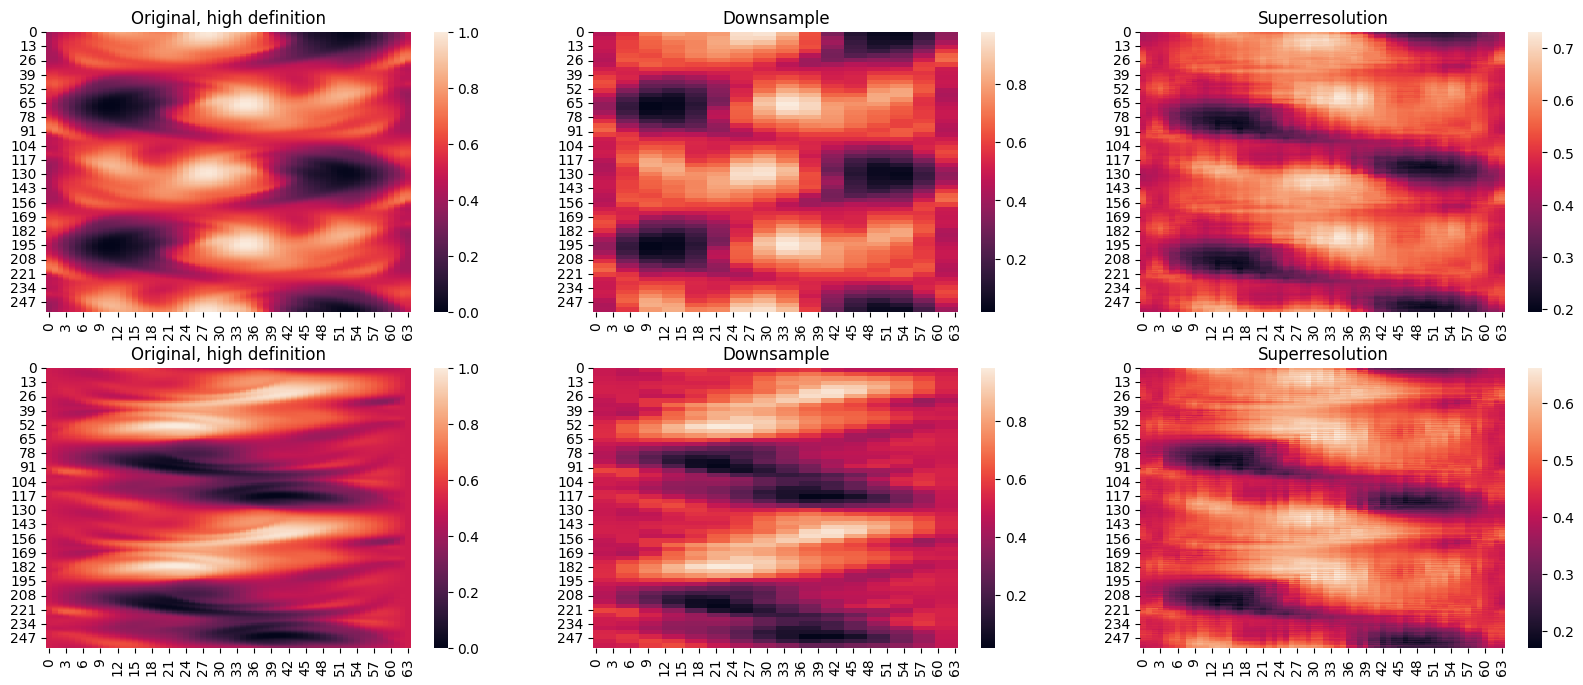

In [65]:
val = 10
X_u_train = X_train[val][:,:,0]
X_v_train = X_train[val][:,:,1]

Y_u_train = Y_train[val][:,:,0]
Y_v_train = Y_train[val][:,:,1]

testX = jnp.dstack([X_u_train,X_v_train])
testY = jnp.dstack([Y_v_train,Y_v_train])

testPred = loaded.forward_pass.apply(loaded.params,X_train[val])

print(jnp.power(jnp.array(testPred) - jnp.array(testY), 2).mean())

print(jnp.power(jnp.array(testX) - jnp.array(testY), 2).mean())

fig, axs = plt.subplots(2,3, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()
vel = 0
im = seaborn.heatmap(Y_train[num][:,:,vel],ax = axs[0])
axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(X_train[num][:,:,vel],ax = axs[1])
axs[1].title.set_text("Downsample")
im = seaborn.heatmap(testPred[:,:,vel],ax = axs[2])
axs[2].title.set_text("Superresolution")

vel = 1
im = seaborn.heatmap(Y_train[num][:,:,vel],ax = axs[3])
axs[3].title.set_text("Original, high definition")
im = seaborn.heatmap(X_train[num][:,:,vel],ax = axs[4])
axs[4].title.set_text("Downsample")
im = seaborn.heatmap(testPred[:,:,vel],ax = axs[5])
axs[5].title.set_text("Superresolution")

In [49]:
# inputs.shape[:-1]

(256, 64)

In [48]:

# inputs = jax.random.uniform(rng_key, (256,64,input_channels))
# expected_output_shape = inputs.shape[:-1] + (num_output_channels,)
# expected_output_shape

(256, 64, 2)

In [36]:
np.shape(scaled_low_def)

(432, 256, 64, 2)

In [37]:
sample_x = jax.random.uniform(rng_key, (256,64,input_channels))
np.shape(X_train[0])

(256, 64, 2)

In [39]:
np.shape(X_train[0])

(256, 64, 2)

In [95]:
test = X_train[:10]

def reshapeData(data):
    for time in range(len(data)):
        data[time] = jnp.dstack([
            data[time][0],
            data[time][1]
        ])
    return data
    
    
    
    
test = reshapeData(test)
np.shape(test)

(10, 64, 2, 2)

In [87]:
learning_rate = jnp.array(0.005)


# this block creates a learning rate that changes after a set number of epochs
def staggeredLearningRate(*args):
    """
    accepts tuples with the following info:
    (number of epochs, learning rate)
    
    example usage: 
    learning_rates = staggeredLearningRate((50,0.005),(50,0.001))
    """
    learning_rates = []
    for arg in args:
        for i in range(arg[0]):
            learning_rates.append(arg[1])
    return learning_rates

learning_rates = staggeredLearningRate((100,0.001))

In [88]:
def train(X_train,Y_train,X_test,Y_test,rng_key,input_channels,epochs,params=None):
    """
    Input parameter 'params' allows us to keep training a network that has already undergone some 
    training, without having to retrain from scratch
    """
    sample_x = jax.random.uniform(rng_key, (256,64,input_channels))

    batch_size = 1
    if params == None:
        params = forward_pass.init(rng_key, sample_x)

    
    print("Shapes of all datasets")
    printAllShapes(X_train,Y_train,X_test,Y_test)
    print("\n")
    
    tol = 1e-5
    losses = []
    val_losses = []
    for i in range(1, epochs+1):

        learning_rate = learning_rates[i-1]

        params,loss,val_loss = train_step(params,X_train,Y_train,X_test,Y_test) #TODO: using test as validation, change this!


        if i%5 == 0: #every 5 epochs
            print("Epoch {:.0f}/{:.0f}".format(i,epochs))
            print("\tmse : {:.6f}\t".format(loss), end='')
            print("\tval mse : {:.6f}".format(val_loss), end='')
            print("\n")
        losses.append(loss)
        val_losses.append(val_loss)

        if i != 1:
            if abs(losses[-2]-losses[-1])<tol:
                print("\nConvergence reached at epoch {:.0f}".format(i))
                print("\tmse : {:.6f}\t".format(loss), end='')
                print("\tval mse : {:.6f}".format(val_loss), end='')
                print("\n")
                break

    if i == epochs:
        print("\nFinished training at max epochs\n")
    
    return losses, val_losses, params

In [90]:
%time losses,val_losses,params = train(X_train,Y_train,X_test,Y_test,rng_key,input_channels,50,params=loaded.params)

Shapes of all datasets
(345, 256, 64, 2)
(345, 256, 64, 2)
(87, 256, 64, 2)
(87, 256, 64, 2)


Epoch 5/50
	mse : 0.009076		val mse : 0.009223

Epoch 10/50
	mse : 0.008718		val mse : 0.008851

Epoch 15/50
	mse : 0.008376		val mse : 0.008497

Epoch 20/50
	mse : 0.008050		val mse : 0.008159

Epoch 25/50
	mse : 0.007739		val mse : 0.007836

Epoch 30/50
	mse : 0.007442		val mse : 0.007530

Epoch 35/50
	mse : 0.007160		val mse : 0.007237

Epoch 40/50
	mse : 0.006891		val mse : 0.006959

Epoch 45/50
	mse : 0.006636		val mse : 0.006695

Epoch 50/50
	mse : 0.006393		val mse : 0.006444


Finished training at max epochs

CPU times: user 1h 6min 41s, sys: 2min 43s, total: 1h 9min 25s
Wall time: 11min 10s


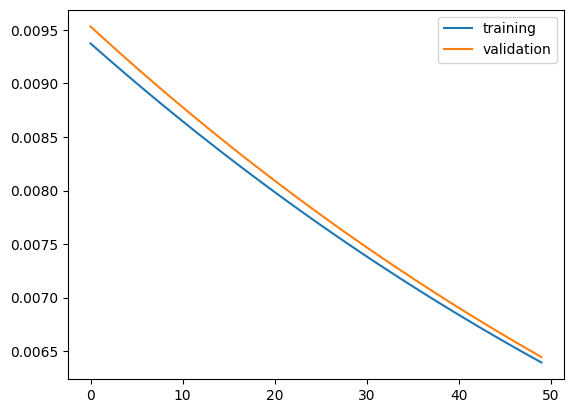

In [91]:
step = 1

plt.plot(losses[::step], label="training")
plt.plot(val_losses[::step],label="validation")
plt.legend()

## Saving model

In [92]:
toSave = SaveObject()
toSave.save_params(params)
toSave.save_forward_pass_params(num_output_channels,ndim,tower_module)

In [93]:
save_path = "./../models/example.pickle"

In [94]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [95]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    loaded.make_forward_pass()
    loaded.preprocess()

## Predicting with model

In [96]:
num =  10 #int(np.random.rand()*np.shape(X_test)[0]//1)
vel = 0      # 0 is u, 1 is v

pred = loaded.forward_pass.apply(loaded.params,X_test[num])

In [97]:
print("Shapes of all datasets")
printAllShapes(X_train,Y_train,X_test,Y_test)
print("\n")

Shapes of all datasets
(345, 256, 64, 2)
(345, 256, 64, 2)
(87, 256, 64, 2)
(87, 256, 64, 2)




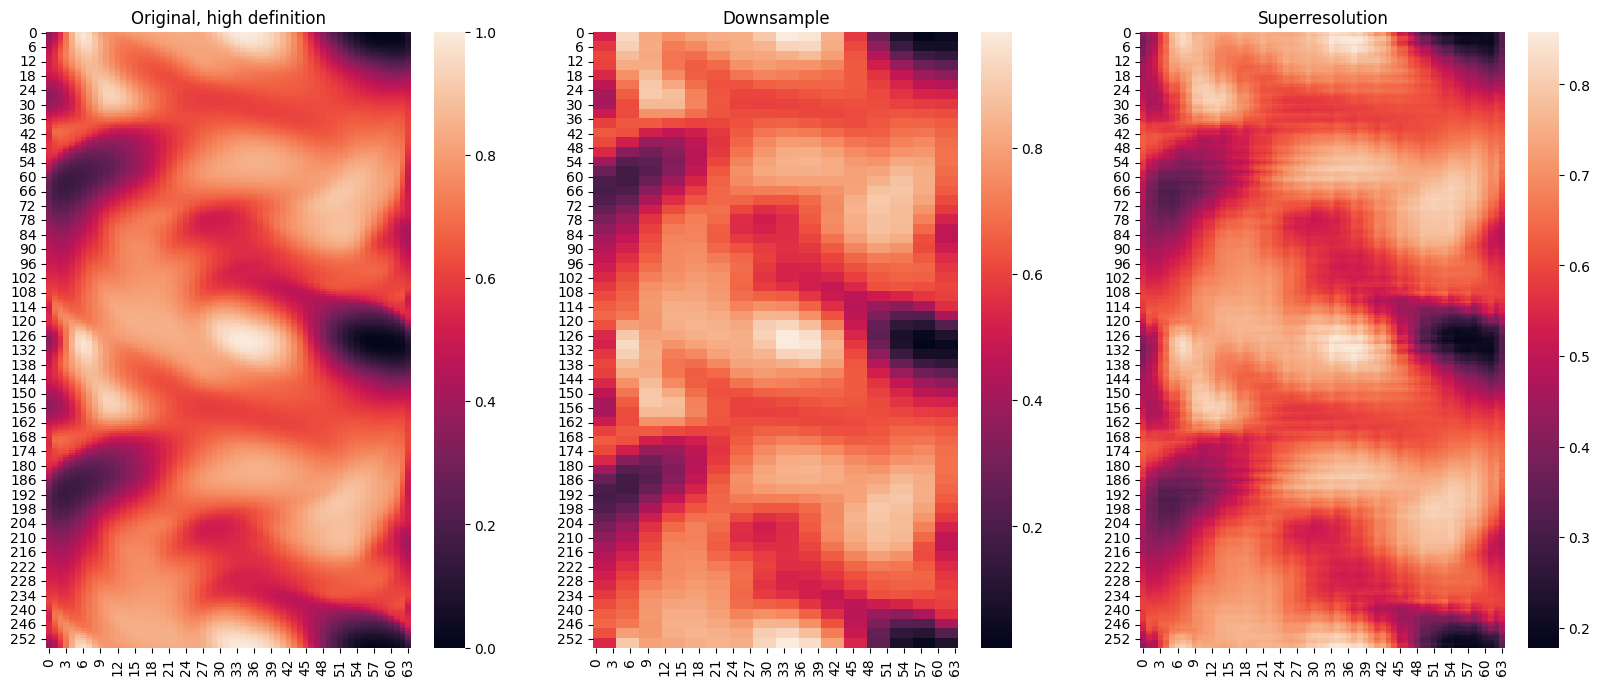

In [98]:
fig, axs = plt.subplots(1,3, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(Y_test[num][:,:,vel],ax = axs[0])
axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(X_test[num][:,:,vel],ax = axs[1])
axs[1].title.set_text("Downsample")
im = seaborn.heatmap(pred[:,:,vel],ax = axs[2])
axs[2].title.set_text("Superresolution")

In [99]:
err_before = mse(X_test[num][:,:,vel],Y_test[num][:,:,vel])
err_after = mse(pred[:,:,vel],Y_test[num][:,:,vel])

print("Error before correction: " + str(err_before))
print("Error after correction: " + str(err_after))

if err_after<err_before:
    print("Error reduced by network, nice")
else:
    print("WARNING: error increased by network")

Error before correction: 0.0012056464
Error after correction: 0.0054277238


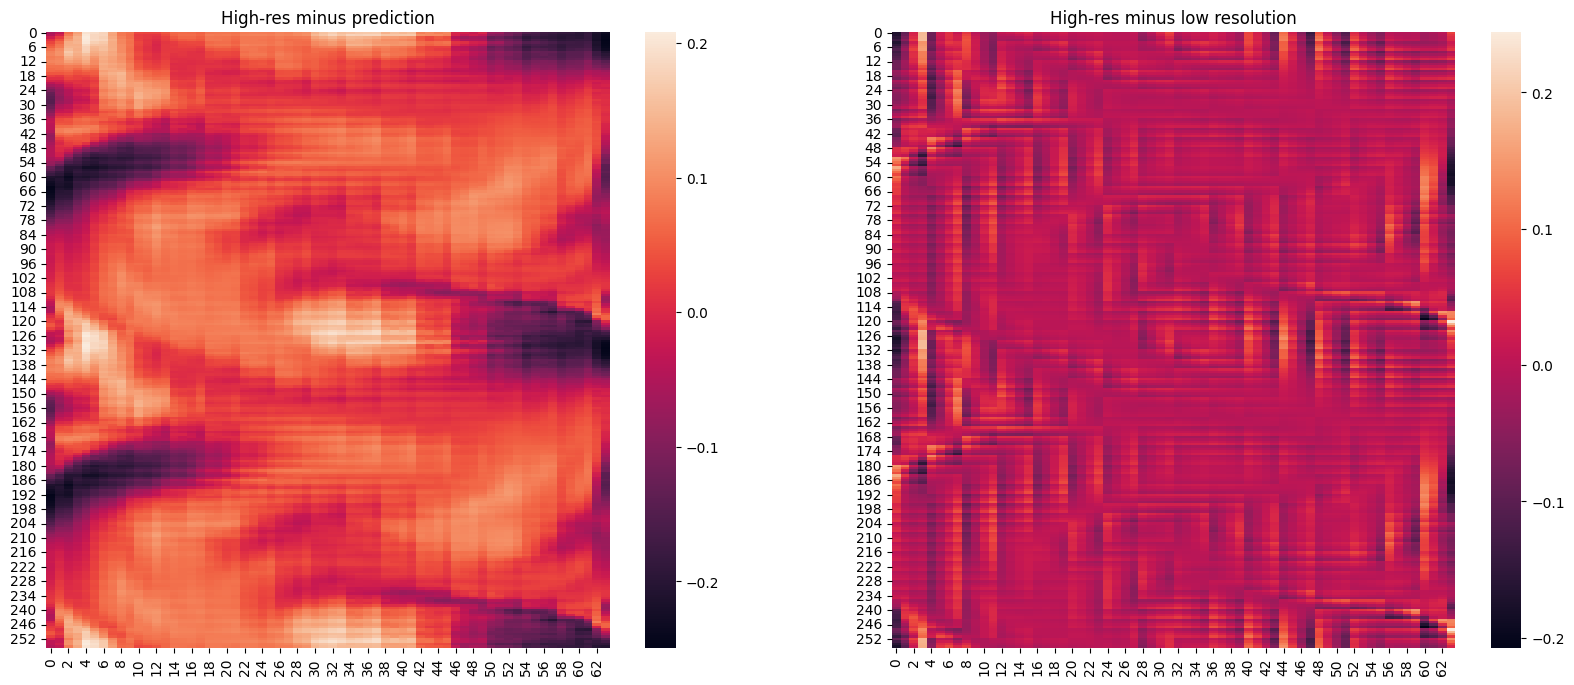

In [100]:
# I think these are called residuals (?)
fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(Y_test[num][:,:,vel]-pred[:,:,vel],ax = axs[0])
axs[0].title.set_text("High-res minus prediction")
im = seaborn.heatmap(Y_test[num][:,:,vel]-X_test[num][:,:,vel],ax = axs[1])
axs[1].title.set_text("High-res minus low resolution")

In [101]:
print(mse(pred[:,:,0],pred[:,:,1]))
print(mse(Y_test[num][:,:,0],Y_test[num][:,:,1]))

0.026727421
0.06949509


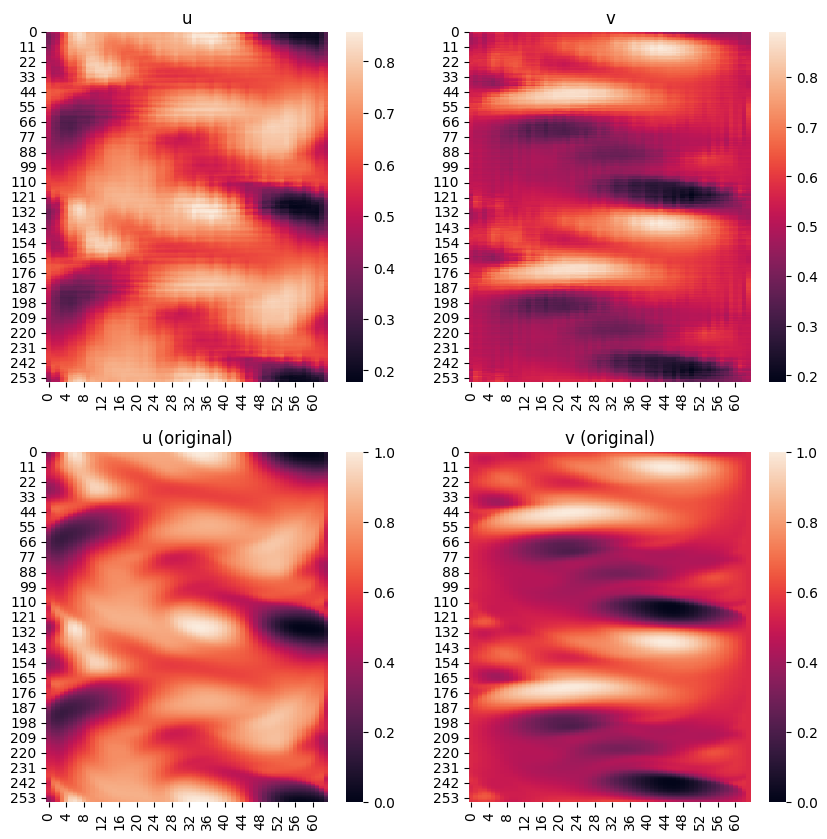

In [102]:
fig, axs = plt.subplots(2,2, facecolor='w', edgecolor='k',figsize=(10,10))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(pred[:,:,0],ax = axs[0])
axs[0].title.set_text("u")
im = seaborn.heatmap(pred[:,:,1],ax = axs[1])
axs[1].title.set_text("v")

im = seaborn.heatmap(Y_test[num][:,:,0],ax = axs[2])
axs[2].title.set_text("u (original)")
im = seaborn.heatmap(Y_test[num][:,:,1],ax = axs[3])
axs[3].title.set_text("v (original)")